In [161]:
import numpy as np
print(np.__version__)


1.26.4


In [163]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [165]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3 #RGB
EPOCHS=50 #trial and error

In [167]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage2",
    shuffle=True, #randomly shuffles imgs
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [169]:
class_names=dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [171]:
len(dataset) #501 elemeants  and each element is 32 batches

501

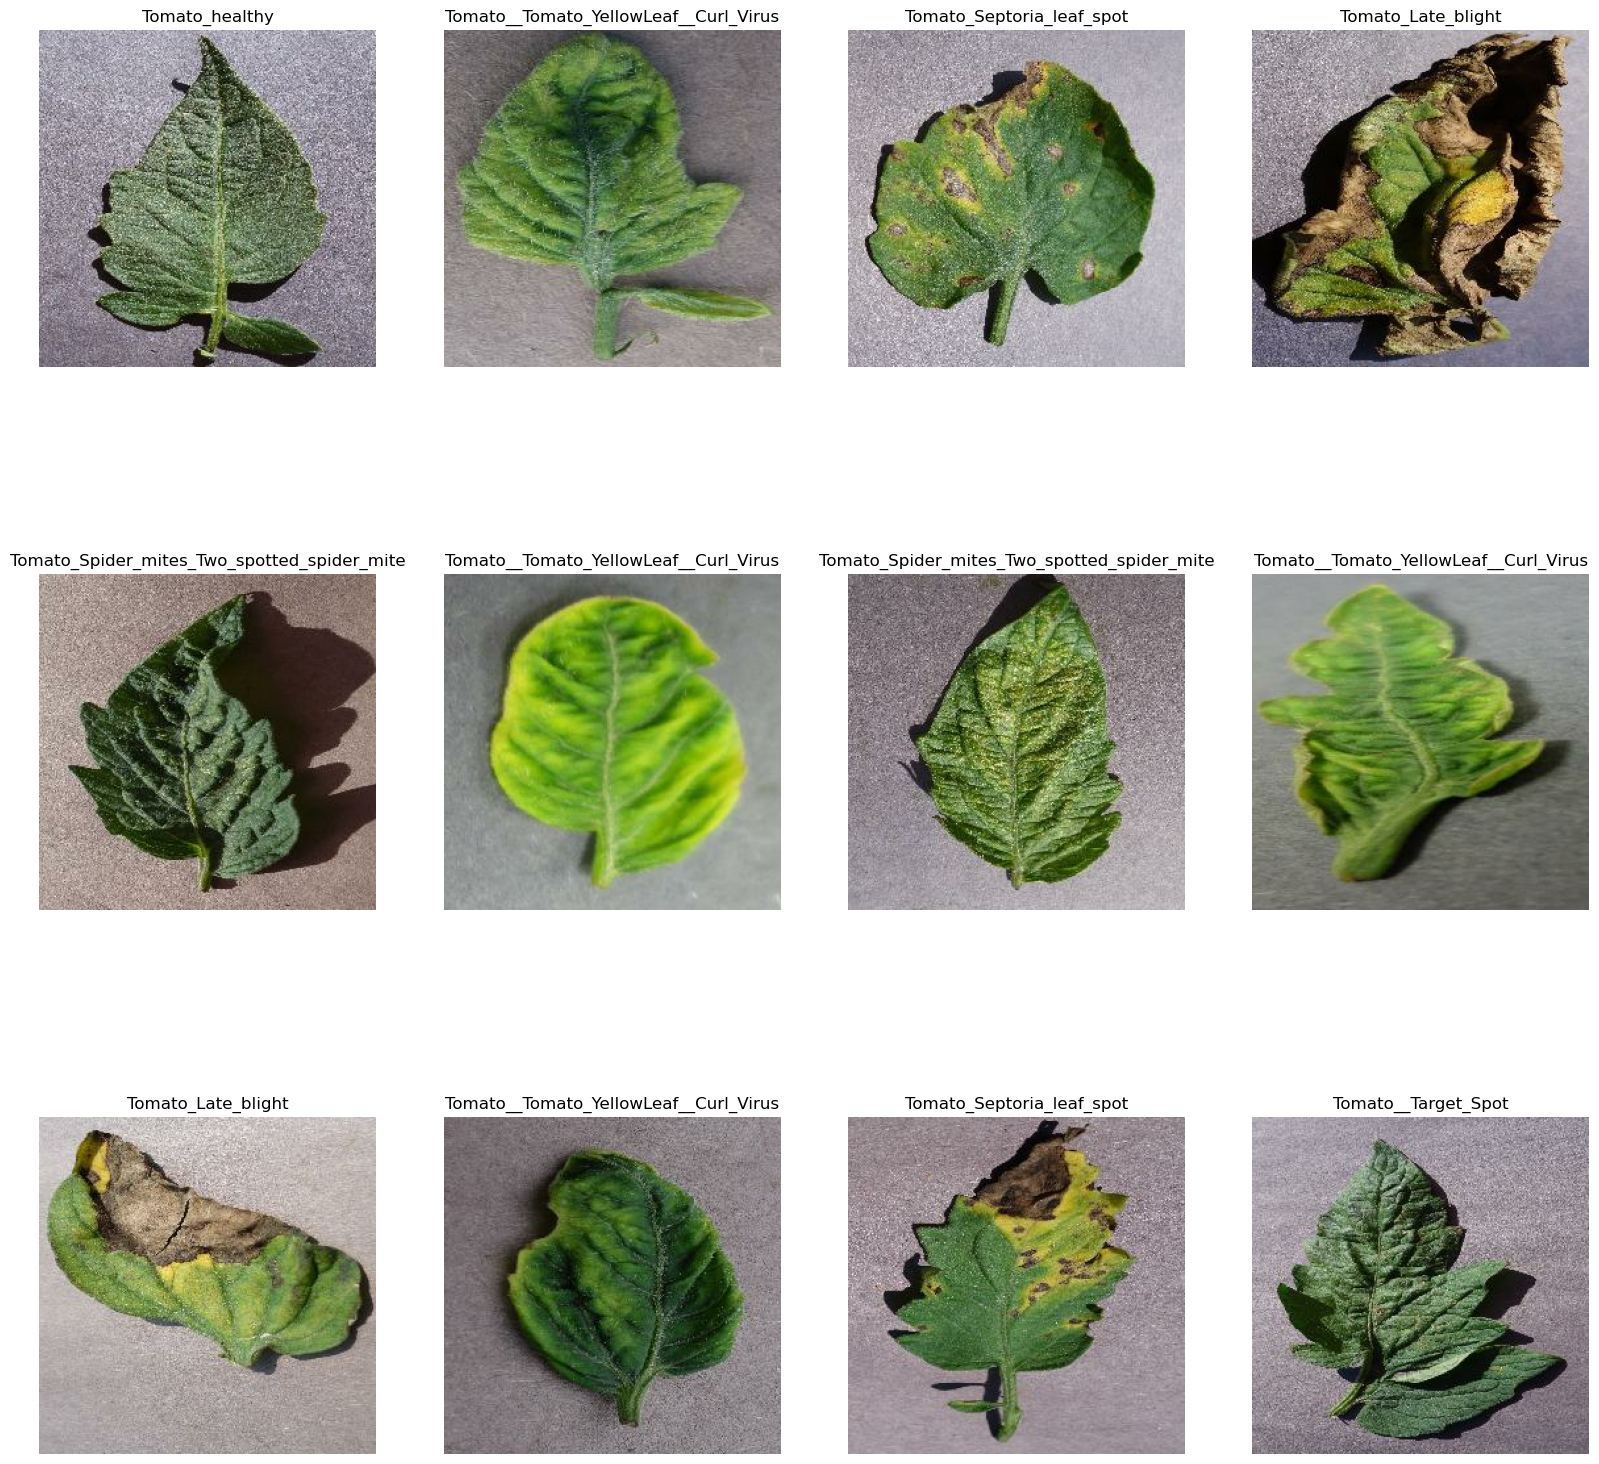

In [173]:
plt.figure(figsize=(20,20))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    
 

In [175]:
#split data
train_size=0.8 # 80 %
len(dataset)*train_size

400.8

In [177]:
train_ds=dataset.take(54)
len(train_ds)

54

In [179]:
test_ds=dataset.skip(54) # remaining 20% data

In [181]:
val_size=0.1 # 10 %  of data
len(dataset)*val_size # no.of samples for validation from the remaining 20% data


50.1

In [183]:
val_ds=test_ds.take(50)
len(val_ds)

50

In [185]:
test_ds=test_ds.skip(50) #actual test ds
len(test_ds)

397

In [187]:

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [189]:

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [191]:
len(train_ds)


400

In [193]:
len(val_ds)


50

In [195]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [197]:
# Image Preprocessing: Rescaling and Resizing
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),  # Resize images to (Image_Size, Image_Size)
    layers.Rescaling(1.0/255)  # Rescale pixel values from [0, 255] to [0, 1]
])


#NOTE:-
#If we give an img i.e  not 256x256 size, then this layer will resize it

In [199]:
#data augmentation :- to make robust
#helps model handle rotated imgs, imgs of diff contrast etc by transforming existing imgs

data_augmentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    
])

In [201]:

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


model.build(input_shape=input_shape)

In [203]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_9 (Sequential)         │ (32, 256, 256, 3)        │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)                │ (32, 254, 254, 32)       │           896 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D)   │ (32, 127, 127, 32)       │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)                │ (32, 125, 125, 64)       │        18,496 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D)   │ (32, 62, 62, 64)         │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)                │ (32, 60, 60, 64)         │        36,928 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D)   │ (32, 30, 30, 64)         │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)                │ (32, 28, 28, 64)         │        36,928 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D)   │ (32, 14, 14, 64)         │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)                │ (32, 12, 12, 64)         │        36,928 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D)   │ (32, 6, 6, 64)           │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)                │ (32, 4, 4, 64)           │        36,928 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D)   │ (32, 2, 2, 64)           │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ flatten_3 (Flatten)               │ (32, 256)                │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_6 (Dense)                   │ (32, 64)                 │        16,448 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_7 (Dense)                   │ (32, 10)                 │           650 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘

 Total params: 184,202 (719.54 KB)

 Trainable params: 184,202 (719.54 KB)

 Non-trainable params: 0 (0.00 B)

In [205]:

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=25,
)

Epoch 1/25
400/400 ━━━━━━━━━━━━━━━━━━━━ 262s 630ms/step - accuracy: 0.3347 - loss: 1.8465 - val_accuracy: 0.6506 - val_loss: 1.0266
Epoch 2/25
400/400 ━━━━━━━━━━━━━━━━━━━━ 250s 625ms/step - accuracy: 0.7336 - loss: 0.7646 - val_accuracy: 0.7487 - val_loss: 0.7328
Epoch 3/25
400/400 ━━━━━━━━━━━━━━━━━━━━ 233s 582ms/step - accuracy: 0.8118 - loss: 0.5547 - val_accuracy: 0.8525 - val_loss: 0.3887
Epoch 4/25
286/400 ━━━━━━━━━━━━━━━━━━━━ 1:01 536ms/step - accuracy: 0.8543 - loss: 0.4176

In [125]:
scores = model.evaluate(test_ds) #testing model on test data

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 1.0000 - loss: 1.0164e-04


In [127]:
scores #o/p is a list in which 1st parameter=loss and 2nd parameter= accuracy

[0.00014060248213354498, 1.0]

In [131]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [133]:
history.history['accuracy'] #accuracy values for all 25 epochs

[0.5381944179534912,
 0.6903935074806213,
 0.8258101940155029,
 0.8709490895271301,
 0.9189814925193787,
 0.9415509104728699,
 0.9427083134651184,
 0.9537037014961243,
 0.9594907164573669,
 0.9722222089767456,
 0.9658564925193787,
 0.9849537014961243,
 0.9890046119689941,
 0.9762731194496155,
 0.9890046119689941,
 0.9849537014961243,
 0.9670138955116272,
 0.9942129850387573,
 0.9803240895271301,
 0.9895833134651184,
 0.9832175970077515,
 0.9953703880310059,
 0.9959490895271301,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

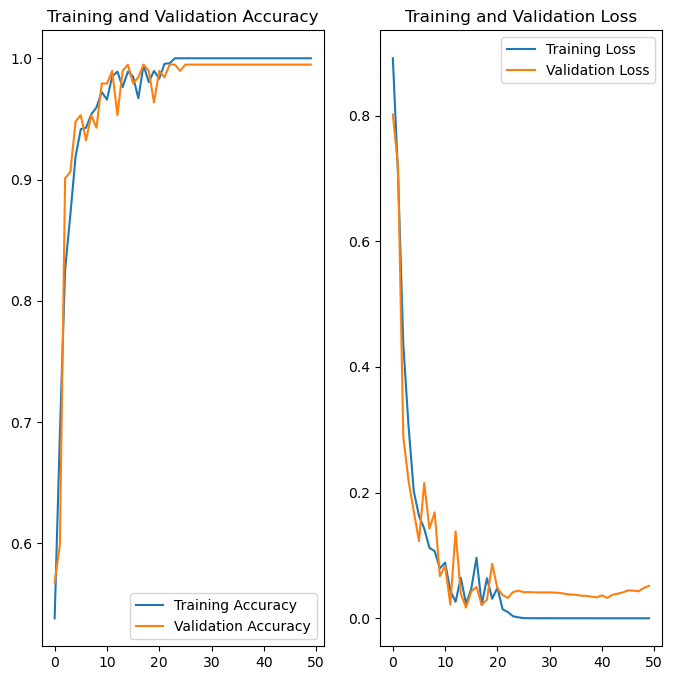

In [135]:
#ploting training and validaition accuracy

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
predicted label: Potato___healthy


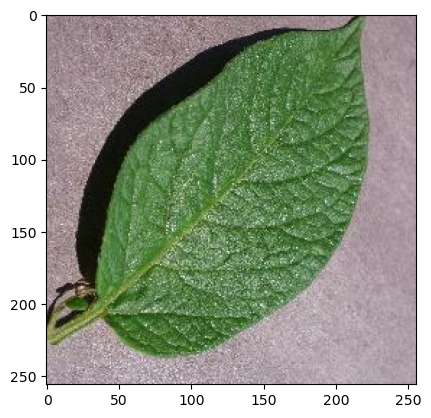

In [145]:
#Runnig prediction on a sample img
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [149]:
#o/p will be predicted class, and confidence
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


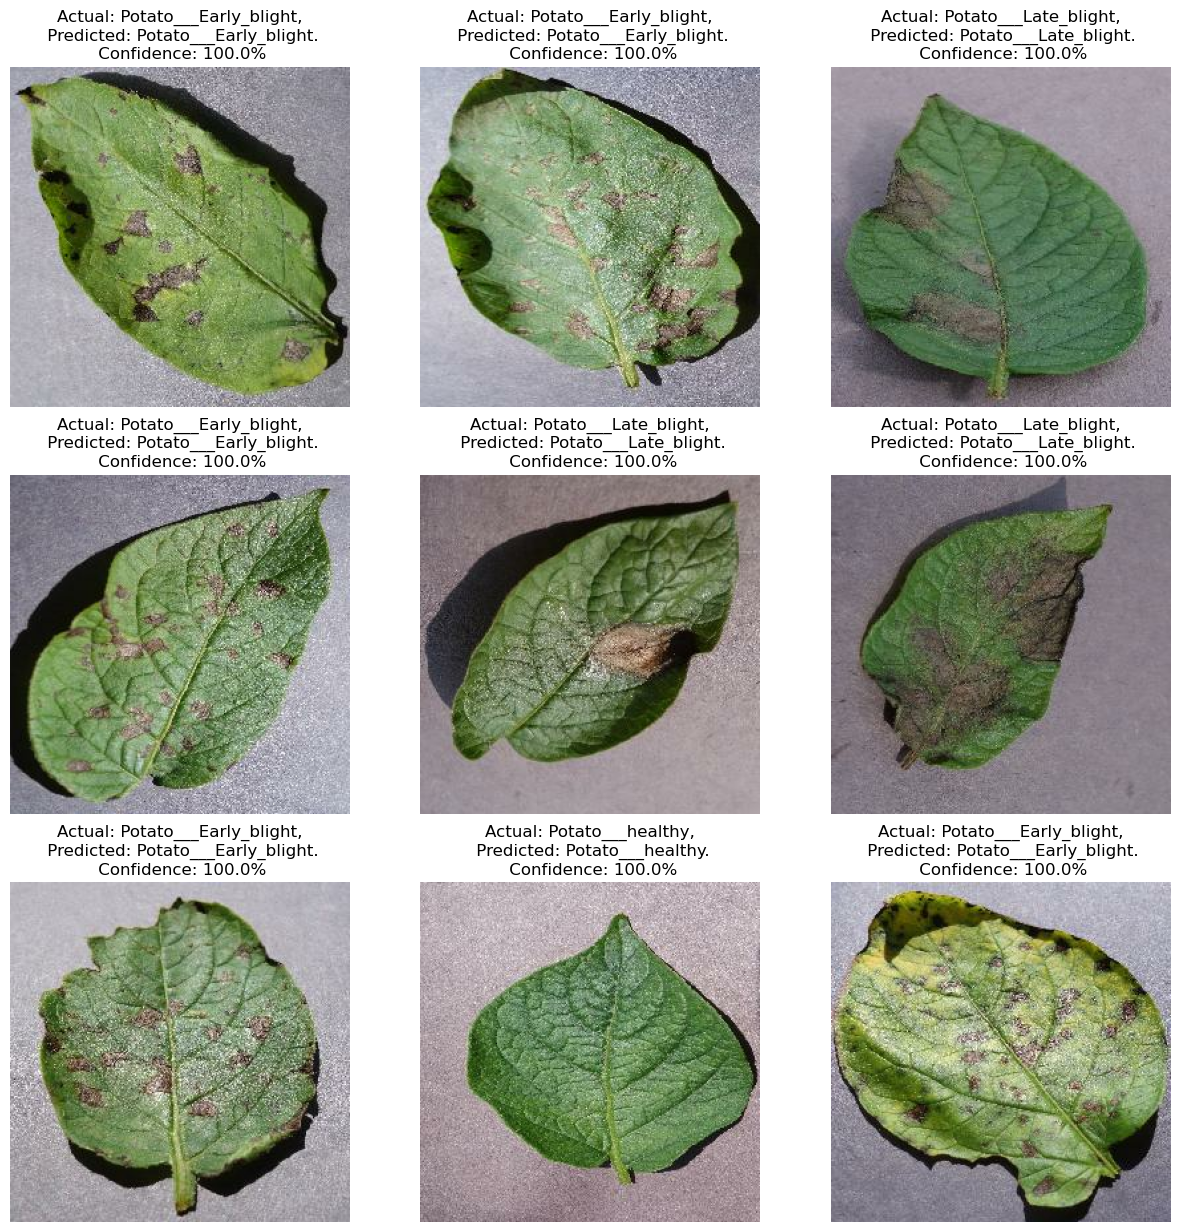

In [155]:
#MAKE PREDICTIOnS

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [167]:
#save the model into to "models" direcotory
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../saved_models/{model_version}.h5")

In [169]:
model.save("../tomatoes.h5")